## Notebook to compare results from the various differential expression methods we used in the ADRD Brain Aging (phase 1) project

Pseudo-replication and zero-inflation are a problem in single-cell data

[Zimmerman KD, Espeland MA, Langefeld CD. A practical solution to pseudoreplication bias in single-cell studies. Nat Commun 2021;12:738.](https://pubmed.ncbi.nlm.nih.gov/33531494/)

we used these methods and are using glmmTMB as gold standard for now
- GLMMTMB
- GLMM (with and without zeros)
- GLM Tweedie (pseudo-bulk)
- diffxpy (t-test)
- Pegasus de_analysis
- Scanpy rank_genes_groups
- scvi-tools differential_expression
- M3Drop selection as input to both scvi and Scanpy

In [1]:
!date

Mon Nov  8 16:05:17 EST 2021


#### import libraries and set variables

In [114]:
import pandas as pd
import numpy as np
import seaborn as sns
from upsetplot import UpSet, from_contents
from upsetplot import generate_counts, plot
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [15]:
# parameters
cohort = 'aging'
assay = 'RNA'

# directories for initial setup
home_dir = '/labshare/raph/datasets/adrd_neuro'
wrk_dir = f'{home_dir}/{cohort}'
results_dir = f'{wrk_dir}/results'

# in files
result_files = {'glmmtmb': f'{results_dir}/{cohort}.glmmtmb_age_diffs.csv',
                'glmm_nz': f'{results_dir}/{cohort}.glmm_nz_age_diffs.csv',
                'glmm_zi': f'{results_dir}/{cohort}.glmm_zi_age_diffs.csv',
                'glm_pb': f'{results_dir}/{cohort}.glm_pb_age_diffs.csv',
                'diffexpy': f'{results_dir}/{cohort}.diffxpy_age_diffs.csv'}

# out files
results_file = f'{results_dir}/{cohort}.age_diffs.csv'

#### load and merge the result sets

In [76]:
results_df = None
keep_cols = ['feature', 'coef', 'score', 'p-value', 'tissue', 'type',
             'fdr_bh', 'method']
for key, value in result_files.items():
    print(key, value)
    this_df = pd.read_csv(value)
    print(this_df.shape)
    this_df['method'] = key
    if key in ['glmm_nz', 'glmm_zi', 'glm_pb']:
        this_df.rename(columns={'z': 'score'}, inplace=True)
    if key == 'glmmtmb':
        this_df.rename(columns={'estimate': 'coef', 'statistic': 'score', 
                                'p.value': 'p-value'}, inplace=True)
    if key == 'diffexpy':
        this_df.rename(columns={'gene': 'feature', 'log2fc': 'score', 
                                'pval': 'p-value'}, inplace=True)
        this_df['coef'] = this_df['score']
    results_df = pd.concat([results_df, this_df[keep_cols]])

glmmtmb /labshare/raph/datasets/adrd_neuro/aging/results/aging.glmmtmb_age_diffs.csv
(226712, 9)
glmm_nz /labshare/raph/datasets/adrd_neuro/aging/results/aging.glmm_nz_age_diffs.csv
(226712, 10)
glmm_zi /labshare/raph/datasets/adrd_neuro/aging/results/aging.glmm_zi_age_diffs.csv
(226712, 10)
glm_pb /labshare/raph/datasets/adrd_neuro/aging/results/aging.glm_pb_age_diffs.csv
(226712, 10)
diffexpy /labshare/raph/datasets/adrd_neuro/aging/results/aging.diffxpy_age_diffs.csv
(503170, 10)


#### get some of the result counts

In [77]:
print(results_df.shape)
display(results_df.head())

(1410018, 8)


,feature,coef,score,p-value,tissue,type,fdr_bh,method
0,AL627309.1,0.437769,2.204596,0.027482,Middle temporal gyrus,brain_region,0.133668,glmmtmb
1,AL627309.5,0.233767,1.573841,0.115524,Middle temporal gyrus,brain_region,0.280980,glmmtmb
2,AC114498.1,2.061367,1.643931,0.100191,Middle temporal gyrus,brain_region,0.260031,glmmtmb
3,AL669831.2,-0.736573,-2.135051,0.032757,Middle temporal gyrus,brain_region,0.145609,glmmtmb
4,LINC01409,0.135679,0.873948,0.382147,Middle temporal gyrus,brain_region,0.564500,glmmtmb


In [78]:
results_df['method'].value_counts()

diffexpy    503170
glmmtmb     226712
glmm_nz     226712
glmm_zi     226712
glm_pb      226712
Name: method, dtype: int64

In [79]:
results_df.loc[results_df['fdr_bh'] <= 0.05]['method'].value_counts()

diffexpy    193740
glmmtmb      17951
glmm_zi       1957
glm_pb         894
glmm_nz        481
Name: method, dtype: int64

#### plot scatters of diff methods against glmmtmb

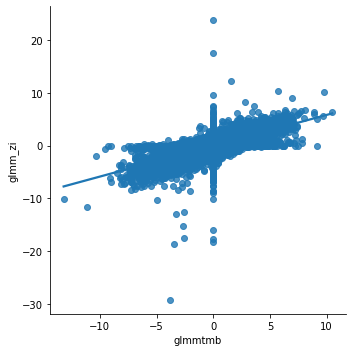

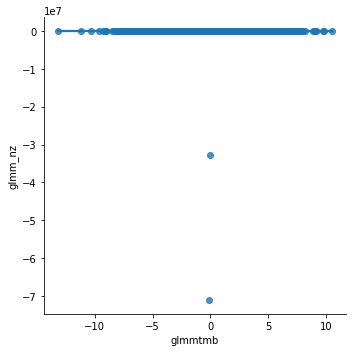

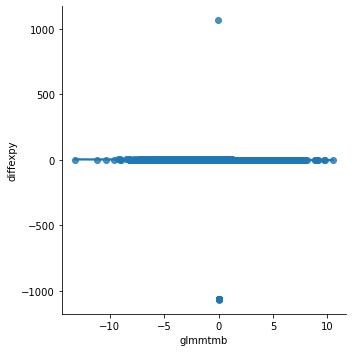

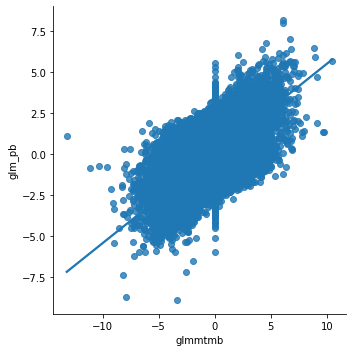

In [82]:
gs_method = 'glmmtmb'
other_methods = set(results_df['method']) - set([gs_method])
for other_method in other_methods:
    these_results = results_df.loc[results_df['method'].isin([gs_method, 
                                                              other_method])]
    this_piv = these_results.pivot_table(values='score', index=['feature', 'tissue'], 
                                         columns='method')
    this_piv = this_piv.fillna(0)
    this_piv = this_piv.replace([np.inf, -np.inf], 0)
#     display(this_piv.head())
    sns.lmplot(data=this_piv, x=gs_method, y=other_method)

In [83]:
gs_method = 'glmmtmb'
other_methods = set(results_df['method']) - set([gs_method])
for other_method in other_methods:
    print(f'{gs_method} vs {other_method}')
    these_results = results_df.loc[results_df['method'].isin([gs_method, 
                                                              other_method])]
    this_piv = these_results.pivot_table(values='score', index=['feature', 'tissue'], 
                                         columns='method')
    this_piv = this_piv.fillna(0)
    this_piv = this_piv.replace([np.inf, -np.inf], 0)
    r2 = r2_score(this_piv[gs_method], this_piv[other_method])
    mape = mean_absolute_percentage_error(this_piv[gs_method], this_piv[other_method])
    mae = mean_absolute_error(this_piv[gs_method], this_piv[other_method])
    mse = mean_squared_error(this_piv[gs_method], this_piv[other_method])
    print(f'r2 score is {r2}')
    print(f'MAPE score is {mape}')
    print(f'MAE score is {mae}')
    print(f'MSE score is {mse}')

glmmtmb vs glmm_zi
r2 score is 0.6307030945457393
MAPE score is 187326343571904.03
MAE score is 0.6940109456770182
MSE score is 1.005044768946523
glmmtmb vs glmm_nz
r2 score is -9968961746.981968
MAPE score is 6.708720116659364e+17
MAE score is 474.2707852869307
MSE score is 27876349310.5457
glmmtmb vs diffexpy
r2 score is -29.963912212521603
MAPE score is 697255418096419.9
MAE score is 0.9760580449860367
MSE score is 40.492749656530755
glmmtmb vs glm_pb
r2 score is 0.48733872358969177
MAPE score is 158345063094011.47
MAE score is 0.850214752009404
MSE score is 1.3947851031167884


In [84]:
other_method = 'glmm_zi'
these_results = results_df.loc[results_df['method'].isin([gs_method, 
                                                          other_method])]
this_piv = these_results.pivot_table(values='score', index=['feature', 'tissue'], 
                                     columns='method')
this_piv = this_piv.fillna(0)
this_piv = this_piv.replace([np.inf, -np.inf], 0)
model_results = smf.ols(formula=f'{gs_method} ~ {other_method}', 
                        data=this_piv).fit()
print(model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                glmmtmb   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                 4.252e+05
Date:                Tue, 09 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:47:11   Log-Likelihood:            -3.1531e+05
No. Observations:              226633   AIC:                         6.306e+05
Df Residuals:                  226631   BIC:                         6.306e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1560      0.002    -72.839      0.0

In [71]:
other_method = 'glm_pb'
these_results = results_df.loc[results_df['method'].isin([gs_method, 
                                                          other_method])]
this_piv = these_results.pivot_table(values='score', index=['feature', 'tissue'], 
                                     columns='method')
this_piv = this_piv.fillna(0)
this_piv = this_piv.replace([np.inf, -np.inf], 0)
model_results = smf.ols(formula=f'{gs_method} ~ {other_method}', 
                        data=this_piv).fit()
print(model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                glmmtmb   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                 2.449e+05
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:25:54   Log-Likelihood:            -3.5212e+05
No. Observations:              226712   AIC:                         7.042e+05
Df Residuals:                  226710   BIC:                         7.043e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3023      0.002   -122.678      0.0

In [165]:
these_results = results_df.loc[results_df['fdr_bh'] <= 0.05]
display(these_results.head())

,feature,coef,score,p-value,tissue,type,fdr_bh,method
8,LINC02593,-1.979733,-3.090203,0.002000,Middle temporal gyrus,brain_region,0.034653,glmmtmb
56,MEGF6,0.310553,3.264499,0.001097,Middle temporal gyrus,brain_region,0.024801,glmmtmb
175,EPHA8,0.914316,3.010140,0.002611,Middle temporal gyrus,brain_region,0.040065,glmmtmb
183,ASAP3,0.322646,3.686370,0.000227,Middle temporal gyrus,brain_region,0.009831,glmmtmb
225,SYTL1,0.691295,3.001267,0.002689,Middle temporal gyrus,brain_region,0.040725,glmmtmb


In [182]:
this_piv = these_results.pivot_table(values='score', index=['feature', 'tissue'], 
                                     columns='method')
# this_piv = this_piv.drop(columns='diffexpy')
display(this_piv.sample(15))

,method,diffexpy,glm_pb,glmm_nz,glmm_zi,glmmtmb
feature,tissue,,,,,
AC092844.1,ExN CUX2 ADARB2,0.714292,NaN,NaN,NaN,-4.344311
TMEM181,Radial Glia,-0.532228,NaN,NaN,NaN,NaN
ZCCHC10,Subventricular zone,0.123513,NaN,NaN,NaN,NaN
ZNF260,InN ADARB2 VIP,0.730167,NaN,NaN,NaN,-4.143121
COL1A2,Endothelial,-0.289791,NaN,NaN,NaN,NaN
AC132872.1,InN ADARB2 VIP,0.594263,NaN,NaN,NaN,NaN
MARCH11,Entorhinal cortex,-0.301536,NaN,NaN,NaN,NaN
NUTM2A-AS1,Middle temporal gyrus,0.057651,NaN,NaN,NaN,NaN
EIF4A1,Oligodendrocyte-2,-0.290638,NaN,NaN,NaN,NaN


In [183]:
for col in this_piv.columns:
    this_piv[col] = np.where(this_piv[col].isna(), False, True)
display(this_piv.sample(15))    

,method,diffexpy,glm_pb,glmm_nz,glmm_zi,glmmtmb
feature,tissue,,,,,
ZNF589,Entorhinal cortex,True,False,False,False,False
SPINK8,Entorhinal cortex,True,False,False,False,False
ACAT1,Middle temporal gyrus,True,False,False,False,False
KAZN-AS1,Radial Glia,True,False,False,False,False
NR3C1,ExN THEMIS,True,False,False,False,False
GHITM,SPN D2,True,False,False,False,False
PSMB6,Subventricular zone,True,False,False,False,False
HHAT,ExN CUX2 LAMP5,True,True,True,True,True
AC026748.3,Entorhinal cortex,True,False,False,False,False


{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

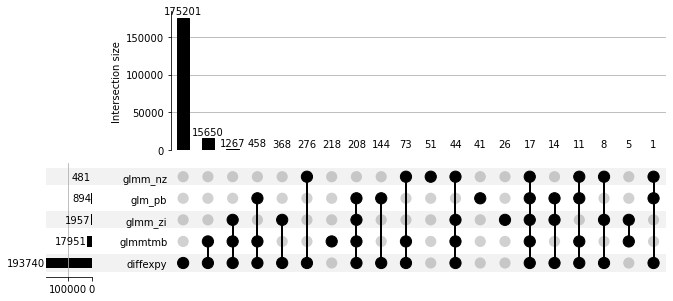

In [184]:
plot(this_piv.groupby(this_piv.columns.to_list()).size(), 
     sort_by='cardinality', show_counts=True)

In [186]:
these_results = results_df.loc[(results_df['fdr_bh'] <= 0.05) & 
                               (results_df['tissue'] == 'Entorhinal cortex')]
display(these_results.head())

,feature,coef,score,p-value,tissue,type,fdr_bh,method
32226,AL357140.4,-0.372784,-3.262961,0.001103,Entorhinal cortex,brain_region,0.024874,glmmtmb
32238,AL139423.1,-0.777838,-2.950726,0.003170,Entorhinal cortex,brain_region,0.044378,glmmtmb
32289,ALDH4A1,-0.308541,-3.053333,0.002263,Entorhinal cortex,brain_region,0.037099,glmmtmb
32315,LINC02596,-0.638003,-3.479199,0.000503,Entorhinal cortex,brain_region,0.015956,glmmtmb
32347,RCAN3AS,-0.507520,-3.048586,0.002299,Entorhinal cortex,brain_region,0.037407,glmmtmb


In [187]:
this_piv = these_results.pivot_table(values='score', index=['feature', 'tissue'], 
                                     columns='method')
# this_piv = this_piv.drop(columns='diffexpy')
display(this_piv.sample(15))

,method,diffexpy,glm_pb,glmm_nz,glmm_zi,glmmtmb
feature,tissue,,,,,
NPDC1,Entorhinal cortex,0.122102,NaN,NaN,NaN,NaN
AP002428.1,Entorhinal cortex,-1.353051,NaN,NaN,NaN,NaN
RAB18,Entorhinal cortex,0.138878,NaN,NaN,NaN,NaN
BFSP1,Entorhinal cortex,0.209823,NaN,NaN,NaN,NaN
EBF4,Entorhinal cortex,0.150567,NaN,NaN,NaN,NaN
SEMA3E,Entorhinal cortex,-0.237429,NaN,NaN,NaN,NaN
BDKRB1,Entorhinal cortex,0.797695,NaN,NaN,NaN,NaN
TRIM72,Entorhinal cortex,0.456381,NaN,NaN,NaN,NaN
LRIF1,Entorhinal cortex,0.337483,NaN,NaN,NaN,NaN


In [188]:
for col in this_piv.columns:
    this_piv[col] = np.where(this_piv[col].isna(), False, True)
display(this_piv.sample(15))    

,method,diffexpy,glm_pb,glmm_nz,glmm_zi,glmmtmb
feature,tissue,,,,,
AC020915.2,Entorhinal cortex,True,False,False,False,False
AC104667.2,Entorhinal cortex,True,False,False,False,False
NARS2,Entorhinal cortex,True,False,False,False,False
MED12L,Entorhinal cortex,True,False,False,False,False
PHLDB2,Entorhinal cortex,True,False,False,False,False
VPS13A,Entorhinal cortex,True,False,False,False,False
AL353747.3,Entorhinal cortex,True,False,False,False,False
AP001056.2,Entorhinal cortex,True,False,False,False,False
RBFOX1,Entorhinal cortex,True,False,False,False,False


{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

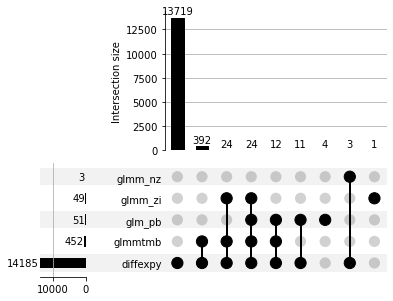

In [189]:
plot(this_piv.groupby(this_piv.columns.to_list()).size(), 
     sort_by='cardinality', show_counts=True)